In [252]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.regularizers import l2
import tensorflow as tf
from PIL import Image

In [209]:
def remove_grid_lines(axs):
    """Remove the default grid lines from a collection of axies."""
    for ax in axs.flatten():
        ax.grid(False)

# Convolutional Neural Networks

Most (all?) machine learning models we have studied so far have been intended to solve very *general* problems.  Convolutional Neural Networks (CNNs) are different, they were designed to address a very specific learning task, **image classification**.

Generalizations of CNNs have been invented to handle other tasks, including

  - audio recognition,
  - sentiment analysis in text, and
  - text generation (for predictive suggestions).  

Many of the main ideas stay mostly the same for these problems, but are adapted to the structure of other types of data.

## Image Classification

**Image Classification** is the task of learning how to label an image.  We are given a set of images to train our model, each with a label identifying its contents:

  - Dog vs. cat
  - Name of a digit (0, 1, ..., 9)
  - Species of a flower

This is a classification problem, so the goal of our algorithm is then to learn the *label* of the image from its *contents* (the features).

### Tensors

We are going to represent images as **tensors**.  Tensors (in machine learning, not mathematics, [tensor](https://en.wikipedia.org/wiki/Tensor) means [something different](http://stats.stackexchange.com/a/198395/74500) in mathematics) are simply multi-dimensional arrays.

  - A one dimensional tensor is a vector.
  - A two dimensional tensor is a matrix.
  - A tensor of larger dimensionality is called a 3-tensor, 4-tensor, etc.
  
So to get an element from a 3-tensor, you need to give it three indices:

```python
three_tensor[i, j, k]
```

And you can slice 3-tensors to get matrices:

```python
# Slicing a 3-tensor by fixing one index gives a 2-tensor, aka a matrix.
three_tensor[i, :, :]
three_tensor[:, j, :]
three_tensor[:, :, k]
```

or vectors:

```python
# Slicing a 3-tensor by fixing one indices gives a 1-tensor, aka a vector.
three_tensor[i, j, :]
three_tensor[:, j, k]
three_tensor[i, :, k]
```

### Grayscale Images

A single greyscale image can be represented as a matrix.  The entries in the matrix represent **pixel intensities**.  A value of 0 represents a white pixel, and a value of zero represents a black pixel.

In [210]:
def one_hotify(y, n_classes=None):
    '''Convert array of integers to one-hot format;
    The new dimension is added at the end.'''
    if n_classes is None:
        n_classes = y.max() + 1
    labels = np.arange(n_classes)
    y = y[..., None]
    return (y == labels).astype(int)

In [211]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
y_train = one_hotify(y_train)
y_test = one_hotify(y_test)

**Note:** Tensorflow has stored this data in *flattened* format, we will unflatten it manually, which is how it would be naturally represented as images.

In [212]:
def plot_greyscale_image(ax, image, label):
    """Plot a greyscale image and label its class."""
    image = image.reshape(28, -1)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Class: {}".format(label))

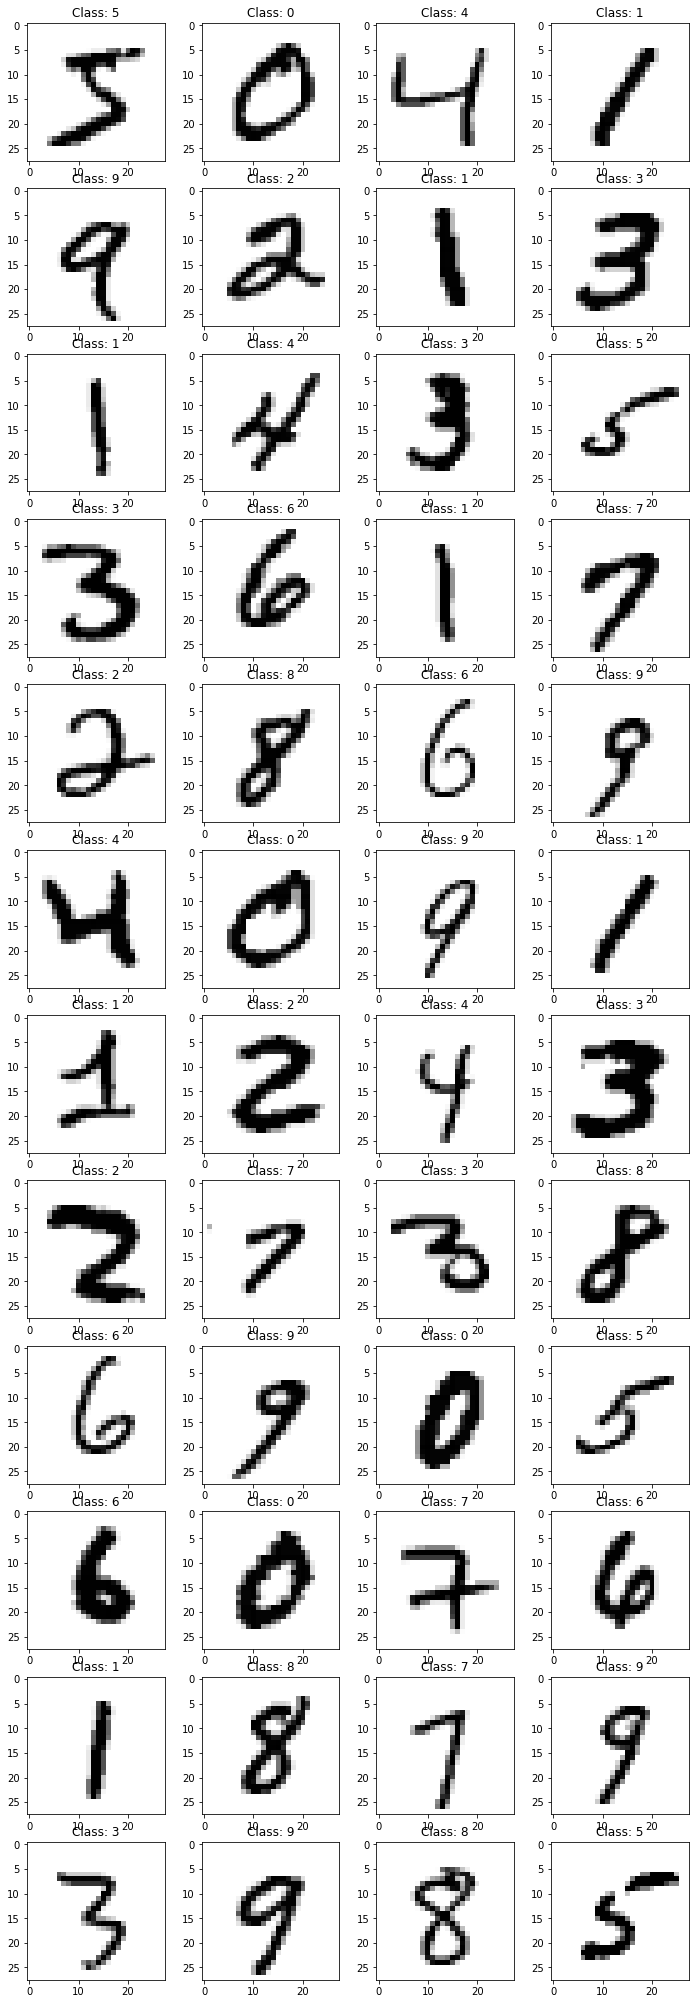

In [215]:
fig, axs = plt.subplots(12, 4, figsize=(12, 36))

digit_labels = np.argmax(y_train, axis=1)

for i, (image, label, ax) in enumerate(
    zip(X_train, digit_labels, axs.flatten())):
    plot_greyscale_image(ax, image, label)
    
remove_grid_lines(axs)

Each image of a digit is represented as a 2-tensor, and is 28 pixels wide and 28 pixels high.

We will often refer to pixel intensities in an image as **activations** n the following way.  Pixels that are "on", or black, are said to be **activated**.  In this way, each digit should be characterized by a characteristic pattern of activations.

In [111]:
digits_training = X_train.reshape(-1, 28, 28)
first_digit_image = digits_training[2]
print("Shape of digit image: {}".format(first_digit_image.shape))

Shape of digit image: (28, 28)


The entire training data is a stack of 28 by 28 images, which is a 3-tensor.

In [112]:
print("Shape of training data: {}".format(digits_training.shape))

Shape of training data: (60000, 28, 28)


Since `plt.imshow` obscures what is going on a bit, below we can build our own simple plotter by drawing a `.` when the pixel intensity is less than 0.5, and drawing a `#` when it is bigger than 0.5.

### Color Images

Color images are more complex than greyscale.

Instead of a single image being represented as a matrix (greyscale), color images are represented as **three matrices**.  Each of these three matrices is called a **channel**, and holds information on one dimension of the color space.

The standard three channels are RGB, or a **red** channel, a **green** channel, and a **blue** channel.

By stacking these together into a 3-tensor, we can represent a color image as a single object.

We will use the [Oxford Flowers Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/index.html) as our example of color images.

To download the data set, use the following shell commands:

```bash
curl http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz > 17flowers.tgz
tar -zxvf 17flowers.tgz
```

You will now have a directory containing many color images of flowers.

Set the following variable to the path of the directory you un-tarred your flower images into.

In [113]:
flowers_path = "/Users/jackbennetto/jpg"

# The number of flower images:
n_flower_images = 1195

# The format specification here left pads zeros on the number: 0004.
flower_filenames = [flowers_path + '/image_{:04d}.jpg'.format(i)
                    for i in range(1, n_flower_images + 1)]

image = Image.open(flower_filenames[501])

We can see the shape of the image when we convert it to a numpy array. The last dimension is the number of channels.

In [114]:
np.array(image).shape

(500, 751, 3)

Here is what they each look like.

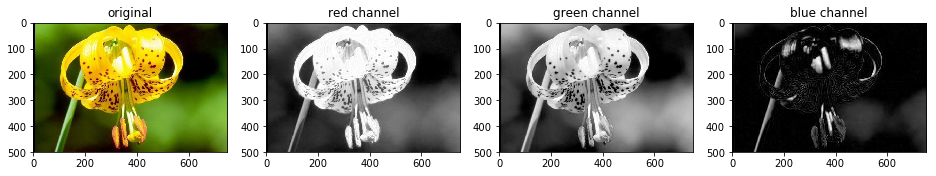

In [115]:
fig, axes = plt.subplots(1, 4, figsize=(16,6))

axes[0].imshow(image)
axes[0].set_title('original')
for ax, channel, name in zip(axes[1:], image.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel, cmap='gray')
    ax.set_title(name)


## Deficiencies of Fully Connected Networks

In a prior assignment, we used a fully connected neural network to classify digits in the MNIST digit dataset.

Let's review that model, and then discuss some deficiencies of the approach.

### Fully Connected Network Review

In a fully connected network we view each pixel of the input image as a feature.  So instead of viewing an input image as a 2-tensor, we instead **flatten** it into a 1-tensor.

![Flattening a Matrix](./img/image-flatten.png)

To classify an image, we create a unique linear combination of the pixel intensity values for each possible class.  Each pixel participates exactly once in each class's linear combination:

$$ L_j = \underbrace{b_j + W_{1j} x_{1j} + W_{2j} x_{2j} + \cdots + W_{pj} x_{pj}}_{\text{One Summand for Each Pixel}} $$

To assign probabilities to each of the classes, we pass our linear combinations through the **softmax** function.

$$ P_j = softmax(b_j + W_{1j} x_{1j} + W_{2j} x_{2j} + \cdots + W_{pj} x_{pj})_j $$

It is common to visualize this as a network diagram with:
    - One input layer, representing the pixel intensities in an image.
    - One pre-output layer, representing the linear combination of pixel intensities.
    - One output layer, containing probabilities.

![Fully Connected Network with No Hidden Lectures](./img/nn-fc-small.png)

It's easy to train this model in keras, so let's do so and see how it performs. Note this has no hidden layers, so won't do very well.

In [230]:
model = Sequential()
model.add(Dense(units=10, activation='softmax', input_dim=28*28))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [117]:
X_train_flat = X_train.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

In [118]:
model.fit(X_train_flat,
          y_train,
          batch_size=100,
          epochs=5,
          verbose=1, 
          validation_data=(X_test_flat, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 44us/step - loss: 7.3619 - acc: 0.5378 - val_loss: 5.7328 - val_acc: 0.6412
Epoch 2/5
60000/60000 [==============================] - 2s 39us/step - loss: 5.7690 - acc: 0.6385 - val_loss: 5.5883 - val_acc: 0.6512
Epoch 3/5
60000/60000 [==============================] - 2s 41us/step - loss: 5.6701 - acc: 0.6459 - val_loss: 5.5907 - val_acc: 0.6505
Epoch 4/5
60000/60000 [==============================] - 2s 40us/step - loss: 5.6119 - acc: 0.6494 - val_loss: 5.5228 - val_acc: 0.6553
Epoch 5/5
60000/60000 [==============================] - 2s 39us/step - loss: 5.5719 - acc: 0.6520 - val_loss: 5.5636 - val_acc: 0.6529


We can do better with a convolutional neural network.

### Flattening

The most glaring deficiency of the fully connected network is its *flattening of the images*.

Images have structure that is destroyed when flattening them.  Pixels that **were** close together become far apart after flattening.

![Image Flattening With Shaded Pixels](./img/img-flatten-non-local.png)

We should expect the neighbouring pixels in an image to combine in ways that convey information.  Flattening the image makes it extremely difficult for the network to detect information conveyed by close together pixels.

We can see this by plotting the fit weights in the fully connected network.

In [119]:
def plot_digit_weights(ax, weights, digit):
    """Plot the weights from our fit fully connected network as an image."""
    digit_weigths = weights[:, digit].reshape(28, -1)
    ax.imshow(digit_weigths, cmap=plt.cm.winter, interpolation="nearest")

In [120]:
model.layers[0].get_weights()

[array([[ 0.07733729,  0.03828963,  0.05612164, ...,  0.05263803,
          0.01701298, -0.00891784],
        [-0.06705025,  0.00739105, -0.04566098, ...,  0.04314534,
          0.05382963,  0.05607573],
        [-0.05361325, -0.03185954,  0.05380198, ...,  0.03640052,
          0.07364953, -0.06302615],
        ..., 
        [ 0.06057858, -0.07899742, -0.06056994, ...,  0.076273  ,
         -0.07991848, -0.05173716],
        [ 0.06401301, -0.07485331,  0.03781471, ..., -0.02624667,
         -0.05344067,  0.04773711],
        [ 0.01392181, -0.04274284,  0.04657286, ..., -0.03981762,
          0.03797709,  0.04968014]], dtype=float32),
 array([-0.06057874,  0.04815018,  0.00842772, -0.07468655,  0.04637439,
         0.09282764, -0.02348723, -0.02195287, -0.03242437, -0.03157451], dtype=float32)]

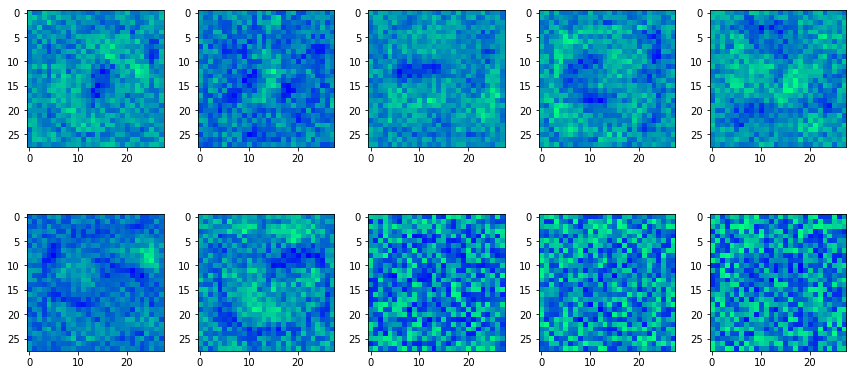

In [121]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for digit, ax in enumerate(axs.flatten()):
    plot_digit_weights(ax,
                       model.layers[0].get_weights()[0],
                       digit)

remove_grid_lines(axs)
plt.tight_layout()

Some digits show considerable structure.

The weights for more others are a bit of a mess.  The network clearly had some issues structuring the weights into comprehensible signal.

### Absolute Positioning

Looking at the weights above again, we can see that the fully connected network is only sensitive to the shape of the digits if they are **in the same general position of the image every time**.

If, for example, we had an image of a $6$, but written in the upper right hand corner of our image, we would totally fail to detect it.  Even retraining the network on a new batch of images that have been shifted or rotated around would not help, as we are assigning weights to each (digit, pixel) combination.

A CNN will learn features that can be applied anywhere in the image, which will fix this issue.

### Number of Parameters

Our fully connected network fits a huge number of parameters.  There are:
  - `n_digits` bias parameters.
  - `n_digits * n_pixels` weight parameters.
  
Overall the network we fit has:

$$ 10 + (10 * 28 * 28) = 7850 $$

parameters.  We will be able to reduce this number with a convolutional approach.

## Image Transformations: Convolutions and Pooling

The major conceptual building block of CNNs are **convolutions**.  These are linear operations that transform an image into another image.

### Gaussian Filter

The earliest application of convolutions in images is **denoising** using a **Gaussian filter**.

Consider the following 2-tensor, called a **filter**.

In [122]:
gaussian_filter = (1/256.0) * np.array([
    [1, 4,  6,  4,  1], 
    [4, 16, 24, 16, 4], 
    [6, 24, 36, 24, 6], 
    [4, 16, 24, 16, 4], 
    [1, 4,  6,  4,  1]
]).astype(np.float32)

We will display these filters as greyscale images, which will make it easier to see their structure, especially as they get more complicated.

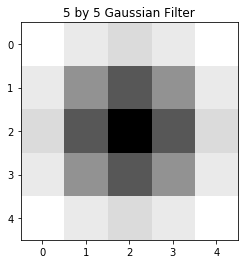

In [123]:
plt.imshow(gaussian_filter, cmap=plt.cm.gray_r, interpolation="nearest")
plt.title("5 by 5 Gaussian Filter")
plt.grid(False)

The numbers in a filter are called it's **weights** or **activations**.  So in the Gaussian filter the biggest weight is in the center, and the values of the weights decrease as we move away from the center.

Scipy has a function `scipy.signal.convolve2d` which **applies** this convolution to an image (or more generally, a tensor). The `mode='same'` ensures the input and output are the same size. Let's see what this operation does to a familiar image.

In [165]:
def plot_convolution(before, convolutional_filter, after, axs):
    """Plot a 1 by 3 grid of images:
        - A before image.
        - A filter to apply.
        - The result of convolving the filter with the image.
    """
    axs[0].imshow(before, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Before Convolution")
    axs[1].imshow(convolutional_filter, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("Filter")
    axs[2].imshow(after, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[2].set_title("After Convolution")

In [166]:
first_digit_blurred = signal.convolve2d(first_digit_image, gaussian_filter, mode='same')

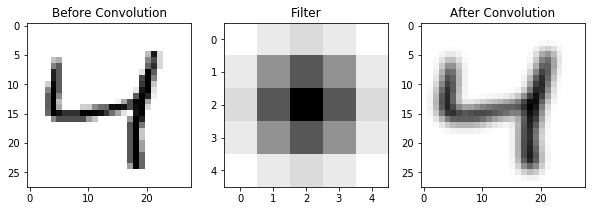

In [167]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

plot_convolution(first_digit_image, gaussian_filter, first_digit_blurred, axs)
remove_grid_lines(axs)

**Discussion:** Given the before and after image, and the shape of the filter we applied, what does the operation of **convolution** do?

### Applying a Convolution to an Image

Remember, a convolution is an operation that *combines an image and a filter to create a new image*.

Lets say we have a *28 by 28* image, and a *3 by 3* filter.  The result of the convolution operation is *another 28 by 28* image.

![A Schematic Of A Convolutional Filter](./img/convolution.png)

As hinted at by the picture, the first step is to *overlay the filter on each 3 by 3 patch of the image*.  By sliding the filter around, we eventually cover each 3 by 3 patch of the image. 

At the edges, the filter will spill out over the boundaries of the image, so we just pretend the values of the pixels are zero outside the image border.

![Example of Filter as a Dot Product](./img/convolution-example.png)

The final pixel value in the output image is a dot product of the pixel intensities underneath the patch, with the weights in the filter directly above the pixel. 

The name of this operation is a **convolution**, so we can say we **convolve the filter with the image to create our output image**.

**Discussion:** Given this understanding, why does convolution with a Gaussian filter result in a *fuzzed out* version of the image?

### Edge Detectors

Another type of interesting filter, which will be most important in understanding how CNNs work, is an **edge detector**.

In [168]:
vertical_edge_filter = np.array([
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1]
]).astype(np.float32)

horizontal_edge_filter = np.array([
    [1,   1,   1,   1,   1],
    [1,   1,   1,   1,   1],
    [0,   0,   0,   0,   0],
    [-1, -1,  -1,  -1,  -1],
    [-1, -1,  -1,  -1,  -1]
]).astype(np.float32)

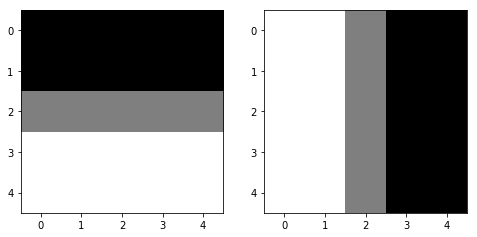

In [169]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].imshow(horizontal_edge_filter, cmap=plt.cm.gray_r, interpolation="nearest")
axs[1].imshow(vertical_edge_filter, cmap=plt.cm.gray_r, interpolation="nearest")

remove_grid_lines(axs)

Edge detectors show a linear pattern in their weights, they tend to be constant in a fixed direction, and vary from positive to negative along an orthogonal direction.

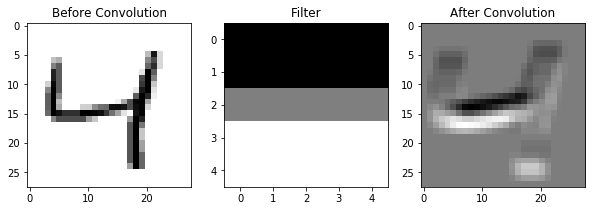

In [170]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

first_digit_h_edges = signal.convolve2d(first_digit_image, horizontal_edge_filter, mode='same')
plot_convolution(first_digit_image, horizontal_edge_filter, first_digit_h_edges, axs)

remove_grid_lines(axs)

**Discussion:** What did the edge detector do, what feature of the image did it highlight?  (Remember, black pixels are the **activations**, you should think about what the back pixels in the convolved image are detecting).

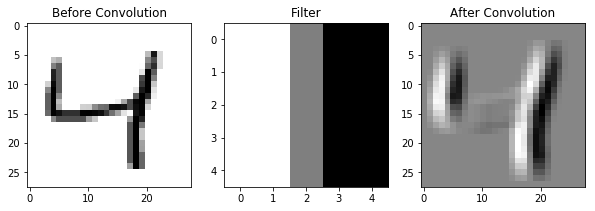

In [171]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

first_digit_v_edges = signal.convolve2d(first_digit_image, vertical_edge_filter, mode='same')
plot_convolution(first_digit_image, vertical_edge_filter, first_digit_v_edges, axs)

remove_grid_lines(axs)

**Exercise:** Design an edge detector to highlight the *diagonal* edges in the image.  Apply it to the image to see it in action!

In [172]:
diagonal_edge_filter = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]).astype(np.float32)

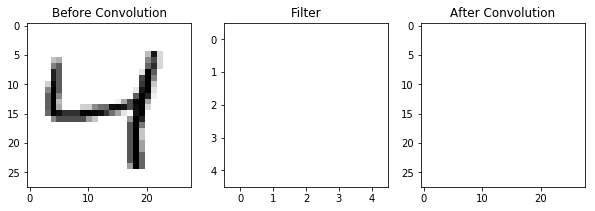

In [173]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

first_digit_d_edges = signal.convolve2d(first_digit_image, diagonal_edge_filter, mode='same')
plot_convolution(first_digit_image, diagonal_edge_filter, first_digit_d_edges, axs)

remove_grid_lines(axs)

### Max Pooling

A more simple transformation of an image into another is **max pooling**.

In max pooling we again overlay smaller squares onto our image, but this time we tile the squares with no overlap.

The final pixel value in the output image is simply the maximum pixel value over all pixels contained in a region defined by one of the small squares.

![Schematic of Max Pooling](./img/pool.png)

In [174]:
def apply_max_pool_to_image(image):
    max_pool = Sequential()
    max_pool.add(keras.layers.MaxPooling2D(input_shape=(*image.shape, 1)))
    return max_pool.predict(image[None, ..., None])[0, :, :, 0]

In [175]:
def plot_max_pool(image, pooled_image, axs):
    axs[0].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Raw Image")
    axs[1].imshow(pooled_image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("Pooled Image")

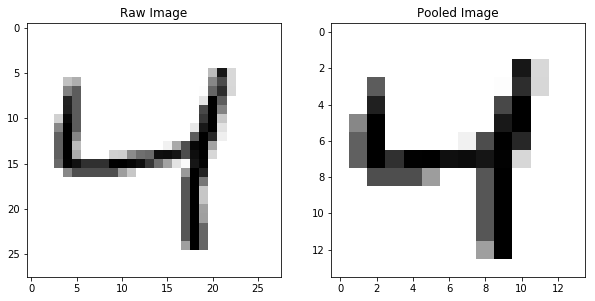

In [176]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

first_digit_pooled = apply_max_pool_to_image(first_digit_image)
plot_max_pool(first_digit_image, first_digit_pooled, axs)

remove_grid_lines(axs)

You can see that max pooling has **downsampled** the image.  We have a smaller image, but displaying the same content at a lower resolution.

Convolutions and max pooling have fundamentally different uses and intent:
  - Convolutions can be used to highlight or manipulate the some structure in an image.
  - Max pooling simply downsamples an image to another of smaller size.

### Rectified Linear Unit

Notice that when we convolve an edge detector with an image, the non-edge parts of the image devolve into a grey sludge:

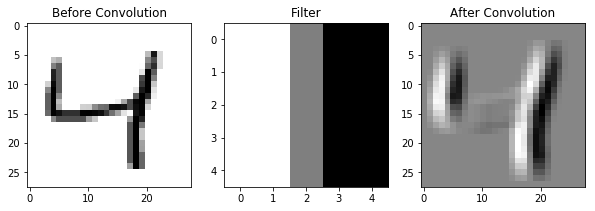

In [177]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

plot_convolution(first_digit_image, vertical_edge_filter, first_digit_v_edges, axs)

remove_grid_lines(axs)

If we are mostly concerned with where there are and are not edges, we are only really concerned with parts of the transformed image where the activations are large and positive.  I.e., the white parts of the convolved image.

A **Rectified Linear Unit** serves to highlight these parts of the image.  It simply implements the following *fixed* transformation:

$$ f(x) = \max(x, 0) $$

In [178]:
def apply_relu(image):
    """Apply a rectified linear unit to an image."""
    return (image * (image >= 0))

In [179]:
def plot_relu(image, rectified_image, axs):
    axs[0].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Initial Image")
    axs[1].imshow(rectified_image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("Rectified Image")

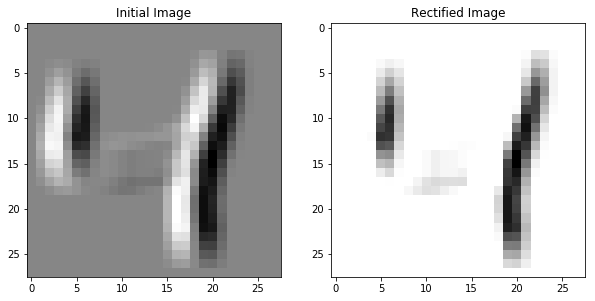

In [180]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

first_digit_v_edges_relu = apply_relu(first_digit_v_edges)

plot_relu(first_digit_v_edges, first_digit_v_edges_relu, axs)
remove_grid_lines(axs)

Now the final image only highlights the regions in the original image where an edge was detected.

#### Chaining Transformations

In CNNs, these three types of transformations are commonly chained together in the sequence:

```
Convolution -> Rectified Linear Unit -> Max Pool
```

Which we can think of as follows:
  - The convolution identifies which regions of an image have a feature.
  - The rectified linear unit highlights only the region where the feature exists.
  - The max pooling downsamples their resulting information to save space and computation.

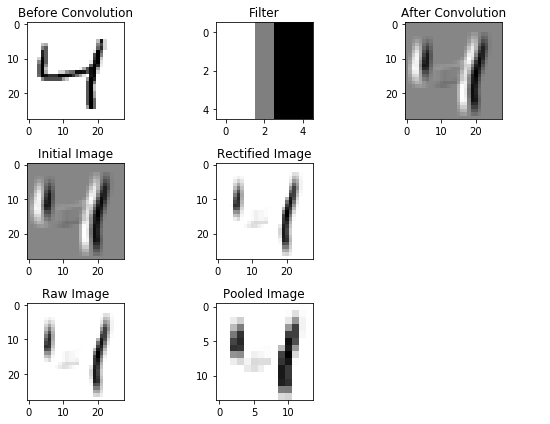

In [181]:
fig, axs = plt.subplots(3, 3, figsize=(8, 6))

plot_convolution(first_digit_image, vertical_edge_filter, first_digit_v_edges, axs[0, :])
plot_relu(first_digit_v_edges, first_digit_v_edges_relu, axs[1, :])
plot_max_pool(first_digit_v_edges_relu,
              apply_max_pool_to_image(first_digit_v_edges_relu),
              axs[2, :])

axs[1, 2].axis('off')
axs[2, 2].axis('off')
remove_grid_lines(axs)
plt.tight_layout()

**Discussion:** How would you detect a *dot* in an image, for example, the dot on the top of a lower case `i`?

**Discussion:** Why use the maximum operation to down sample an image, instead of an average or other operation.

## Convolutional Neural Network Architecture

A convolutional neural network works, as the name hints, by dissecting an image through applying various convolutions.

During training, the job of the network is to discover, from the data, appropriate convolutions that highlight features of the images which help to distinguish between the various classes we are attempting to learn.

The architecture is *layered*, as in the image below:

![Schematic of a Complete CNN Beginning](./img/deep-network-begin.png)
![Schematic of a Complete CNN End](./img/deep-network-end.png) 

There are two layers in the CNN above (though what exactly constitutes a layer seems to vary across sources).  Each layer implements the chained transformation we discussed above:
    
```
Convolution -> Rectified Linear Unit -> Max Pool
```

In our network, we've chained together two layers, followed by a fully connected layer, which connects to an output layer, in the same way as in fully connected networks:

```
INPUT -> (CONV -> RELU -> POOL) -> (CONV -> RELU -> POOL) -> FULL-CONN -> OUTPUT
```

Below, we will discuss the details of these two layers.  We will assume that our network is **already trained**, so we will be describing a **forward pass**, i.e. what happens to an image that is fed into the network.

### The First Layer

The first layer of our CNN acts on the initial image:
    
```
INPUT -> (CONV -> RELU -> POOL) -> ...
```

We already understand what this does when `CONV` is a *single* convolutional filter, this is what we discussed extensively in the previous session.

In a CNN though, the `CONV` unit applies **multiple** convolutional filters to the image.

![First Layer Convolutional Filter](./img/convolution-first-layer.png)

Suppose our input image is 28 by 28.  Since there is one image, and we have one color channel (greyscale) we can consider this a 4-tensor of dimensions `(1, 28, 28, 1)`, where:

  - The first `1` is the *one image*.
  - The last `1` is the *one channel*.
  
Suppose that we have sixteen convolutional filters in our first layer.  Each filter is applied to the image independently, so the result is **eight 28 by 28 images**.

Here we re-use some terminology, the eight output images are again called **channels**, so the output of the first convolutional layer is a tensor with sixteen channels.

So, in all, our dimensions transform as:

```
(1, 28, 28, 1) --EIGHT CONVOLUTIONS--> (1, 28, 28, 8)
```

**Convention:** Whenever we have a tensor holding *data*, i.e. an image, multiple images, or transformed images, we will use the following convention for our dimensions:

```
(n_input_images, image_height, image_width, n_channels)
```

After the convolutions, the `RELU` and `POOL` simply act over each channel independently.  So the dimensions work out as:

```
(1, 28, 28, 1) --CONV--> (1, 28, 28, 8)
               --RELU--> (1, 28, 28, 8)
               --POOL--> (1, 14, 14, 8)
```

#### Keras Code
Let's create a keras model for a convolutional neural network. Keras abstracts most of the details away, some it's mostly just adding some layers.

For the first layer, we'll add a `Conv2D` layer. The "2D" is because we're dealing with images; there's also a Conv1D (generally for time-series data) and Conv3D (for spacial data or video).

The `filters` parameter controls the number of different output channels to include. The shape of the convolution is given by `kernel_size`. With the `strides` parameter we specify we want to consider every position. We'll include the ReLU activation automatically. We just have one channel in our 28x28 image, so `input_shape=(28, 28, 1)`.

Finally, will add L2 regularization on all the weights in the network to prevent overfitting.  This is generally a good idea and much effort in training production CNNs is spent validating the choice of this (regularization strength) and other hyperparameters. 

In [314]:
model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(28, 28, 1),
                 kernel_regularizer=l2(0.01)))

Next is the maxpool layer. Again, it's 2-dimensional. We'll pool 2x2 regions as described above (the `pool_size`) positioned at intervals of 2 in each direction (`strides`), so they won't overlap.

In [315]:
model.add(MaxPooling2D(pool_size=(2, 2),
                       strides=(2, 2)))

#### Structure of the First Layer Convolutional Filters

The first layer of convolutions in a well constructed CNN frequently show the same type of structures.  The tend to be **edge and point detectors**.

For an example if filters, see http://cs231n.github.io/convolutional-networks/#conv  These filters have very clearly converged to edge and color blob detectors.

### The Second Layer

The second layer of our CNN acts on (takes as input) the output of our previous layer:
    
```
LAYER_1_OUTPUT -> (CONV -> RELU -> POOL) -> ...
```

This means that the *input* data tensor is a 4-tensor with shape `(1, 14, 14, 8)`.  Recall from above, this tensor represents a *stack of 16 images*.

**Question:** How should we generalize our concept of **convolution** to process a *stack* of images?

**Our prior concept** of a convolution processed a single image (2-tensor) using a filter, which was also a 2-tensor.  Each of our filters in our convolutional unit had a shape:

```
(filter_height, filter_width)
```

and was combined with an image of shape:

```
(image_height, image_width)
```

![A Schematic Of A Convolutional Filter](./img/convolution.png)

**Now** we need to process a 3-tensor (stack of images), so our filter will *also* need to be a 3-tensor.  We will generalize the above to have filters of shape:

```
(filter_height, filter_width, filter_depth)
```

Which we will combine with an image of shape:

```
(image_height, image_width, n_channels)
```

This combination is a direct generalization of the previous case, we only overlay **volumes** instead of **areas**.

![Three Dimensional Filter](img/three-dim-filter.png)

We always make one simplifying restriction in the context of CNNs:

> We will always use filters whose depth is **equal** to the numbers of channels in the image.

Altogether, our second (and subsequent) convolutional layers will have a 4-tensor of weights, of shape:

```
(filter_height, filter_width, input_channels, output_channels)
```

This means there are

```
filter_height * filter_width * input_channels * output_channels
```

total convolutional weights in this layer.

This layer transforms an input tensor of shape

```
(n_input_images, image_height, image_width, n_channels)
```

into an output tensor of shape

```
(n_input_images, image_height, image_width, new_n_channels)
```

**Note:**  These convolutional layers are impossible to draw an accurate picture of, as we cannot draw four dimensional volumes.  I'll continue to draw them as three dimensional parallelepipeds, but you should keep in mind that the truth is slightly more complicated.

#### Example: Identifying a Higher Level Feature

To see what a later convolutional layer is trying to do, let's consider a simple example.

In [198]:
zero_digit = digits_training[1]

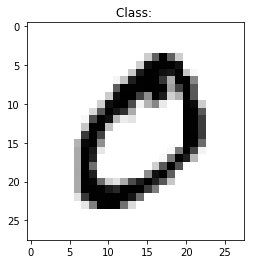

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_greyscale_image(ax, zero_digit, "")
ax.grid(False)

Let's see how we can combine *two* convolutional layers to detect the upper left hand arc of the zero in this picture.

It's not possible to detect this feature with the simple linear edge detectors we have discussed up until now, but we *can* combine them to get the job done.

Let's start by applying our three edge detectors to this image.

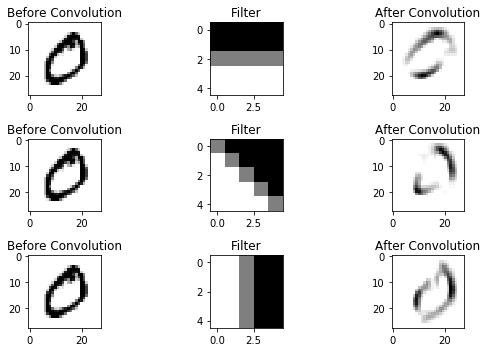

In [205]:
fig, axs = plt.subplots(3, 3, figsize=(8, 5))

zero_digit_h_edges = apply_relu(signal.convolve2d(zero_digit, horizontal_edge_filter, mode='same'))
plot_convolution(zero_digit, horizontal_edge_filter, zero_digit_h_edges, axs[0, :])

diagonal_edge_filter = np.array([
    [ 0,   1,    1,  1,   1],
    [-1,   0,    1,  1,   1],
    [-1,  -1,    0,  1,   1],
    [-1,  -1,   -1,  0,   1],
    [-1,  -1,   -1, -1,   0]
]).astype(np.float32)

zero_digit_d_edges = apply_relu(signal.convolve2d(zero_digit, diagonal_edge_filter, mode='same'))
plot_convolution(zero_digit, diagonal_edge_filter, zero_digit_d_edges, axs[1, :])

zero_digit_v_edges = apply_relu(signal.convolve2d(zero_digit, vertical_edge_filter, mode='same'))
plot_convolution(zero_digit, vertical_edge_filter, zero_digit_v_edges, axs[2, :])

remove_grid_lines(axs)
plt.tight_layout()

If we imagine that these edge detectors are the first convolutional layer of our CNN, then the output of this layer is a 3-tensor with the max-pooled outputs of the edge detectors stacked together.

--> Image of 3 convolution layer applied to zero.

In [206]:
stacked_filtered_zeros = np.stack([
    apply_max_pool_to_image(zero_digit_h_edges),
    apply_max_pool_to_image(zero_digit_d_edges),
    apply_max_pool_to_image(zero_digit_v_edges) 
], axis=-1)

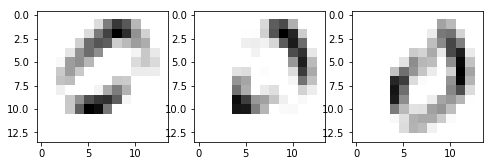

In [207]:
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
axs[0].imshow(stacked_filtered_zeros[:, :, 0], cmap=plt.cm.gray_r, interpolation="nearest")
axs[1].imshow(stacked_filtered_zeros[:, :, 1], cmap=plt.cm.gray_r, interpolation="nearest")
axs[2].imshow(stacked_filtered_zeros[:, :, 2], cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

To detect the curve of the upper left hand side of the zero, we will construct a convolution in our second layer that "glues together" the edge detectors.

More precisely, we will attempt to detect the *pattern of activations* from the convolutions in the first layer:
  - The activation from the horizontal edge detector at the top.
  - The activation from the diagonal detector slightly below and to the right of that.
  - The activation from the vertical detector slightly below and to the right of that.

In [216]:
# This is a simple template for a blob detector.
template = np.array([
    [0.25, 0.5, 0.25],
    [0.5,  1.0, 0.5],
    [0.25, 0.5, 0.25],
])

# Put together three blob detectors in the correct pattern.
three_filter = np.zeros((5, 5, 3), dtype=np.float32)

three_filter[:3, :3, 0] = template
three_filter[1:4, 1:4, 1] = template
three_filter[2:, 2:, 2] = template

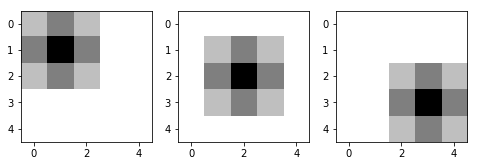

In [217]:
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
axs[0].imshow(three_filter[:, :, 0], cmap=plt.cm.gray_r, interpolation="nearest")
axs[1].imshow(three_filter[:, :, 1], cmap=plt.cm.gray_r, interpolation="nearest")
axs[2].imshow(three_filter[:, :, 2], cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

You can think of these filters as identifying where to "glue" the detectors from the first layer to create a pattern that will detect the curve we are after.

In [218]:
def apply_three_convolution_to_image_stack(images, filters):
    images_shape = images.shape
    image_tensor = tf.constant(
        images.reshape(1, images_shape[0], images_shape[1], images_shape[2]))
    filters_shape = filters.shape
    filter_tensor = tf.constant(
        filters.reshape(filters_shape[0], filters_shape[1], filters_shape[2], 1))
    convolved_tensor = tf.nn.conv2d(
        image_tensor, filter_tensor, 
        strides=[1, 1, 1, 1], padding='SAME')
    image_convloved = convolved_tensor.eval()[0, :, :, 0]
    return image_convloved

In [219]:
double_filtered_image = apply_three_convolution_to_image_stack(
    stacked_filtered_zeros, three_filter)

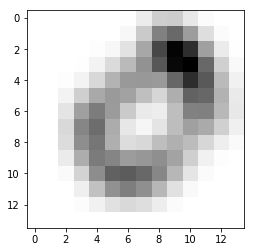

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(double_filtered_image, cmap=plt.cm.gray_r, interpolation="nearest")
ax.grid(False)

The strong activation in this picture (the mass of dense black pixels) serves to detect the feature we are after.

Essentially, if we lay down our three edge detectors from the first layer in the pattern defined by the second layer, centered on the point of strongest activation in the image above, we will detect the curve of the upper right hand side of the zero.

#### Keras Code

Our network will contain 32 convolutional filters in the second layer.

This means we are creating 32 "patterns" for gluing the 8 convolutions from the **first** layer together so as to detect more complex features.

This means that overall, the second layer transforms the dimensions of the input tensor as:

```
(1, 14, 14, 8) -CONV-> (1, 14, 14, 32)
               -RELU-> (1, 14, 14, 32)
               -POOL-> (1, 7, 7, 32)
```

In [316]:
model.add(Conv2D(filters=32, kernel_size=(5, 5),
                 strides=(1, 1),
                 activation='relu',
                 kernel_regularizer=l2(0.01)))

model.add(MaxPooling2D(pool_size=(2, 2),
                       strides=(2, 2)))

### The Fully Connected Layer

To finish off the network, we add a fully connected layer, and then an output layer.

![Schematic of a Complete CNN End](./img/deep-network-end.png) 

First, we need to add a layer to `Flatten` the 2-D data. The we have a fully connected layer that will contain 128 final numeric features which are linear combinations of the higher level features from the second convolutional layer.

Finally we add an output layer with 10 classes, one for each digit. As in with the fully connected model we use a softmax activation.

In [317]:
model.add(Flatten())
model.add(Dense(128,
                activation='relu',
                kernel_regularizer=l2(0.01)))
model.add(Dense(10,
                activation='softmax',
                kernel_regularizer=l2(0.01)))

### Training the Network

#### Loss Function and Regularization

To train our network, we need to set up a loss function.

As usual, we train our network by minimizing a cross entropy loss function. We will use a more sophisticated method than vanilla stochastic gradient descent, and use a very small learning rate.

In [318]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

#### Training The Network

Now let's run our training algorithm.  This takes a **long time** to well train. We will keep track of training and testing error as we go. Note that the model assumes 4-dimensional input (for data, height, width, and channels) we need to reshape our data.

In [319]:
model.fit(X_train[..., None], y_train,
          epochs=5,
          verbose=1,
          batch_size=50,
          validation_data=(X_test[..., None], y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 45s 746us/step - loss: 2.0791 - acc: 0.8911 - val_loss: 0.4239 - val_acc: 0.9804
Epoch 2/5
60000/60000 [==============================] - 43s 716us/step - loss: 0.2918 - acc: 0.9775 - val_loss: 0.2040 - val_acc: 0.9784
Epoch 3/5
60000/60000 [==============================] - 43s 710us/step - loss: 0.1789 - acc: 0.9790 - val_loss: 0.1564 - val_acc: 0.9800
Epoch 4/5
60000/60000 [==============================] - 45s 749us/step - loss: 0.1496 - acc: 0.9805 - val_loss: 0.1403 - val_acc: 0.9812
Epoch 5/5
60000/60000 [==============================] - 47s 784us/step - loss: 0.1377 - acc: 0.9815 - val_loss: 0.1371 - val_acc: 0.9796


#### Visualizing the First Layer

Now we can visualize the fit convolutions in the first layer of our network. We can see a list of our layers.

In [320]:
model.layers

And get the shape of the weight matrix from the 1st convolutional layer.

In [321]:
weights1 = model.layers[0].get_weights()[0]
weights1.shape

(5, 5, 1, 8)

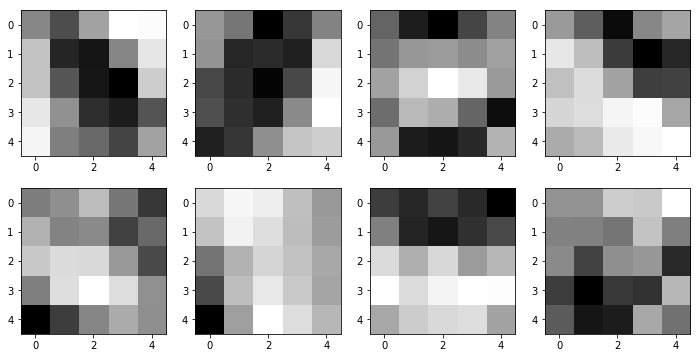

In [322]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    filter = weights1[:, :, 0, i]
    ax.imshow(filter, cmap=plt.cm.gray_r, interpolation="nearest")
    
remove_grid_lines(axs)

As stated earlier, the first layer convolutions show characteristic signs of being edge detectors.

Let's apply these filters to our digit from earlier:

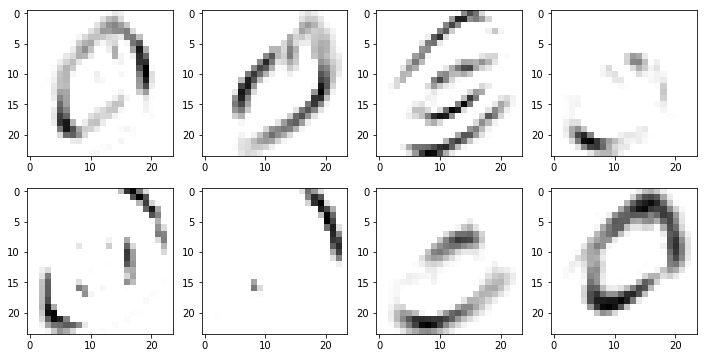

In [330]:
first_layer = Model(model.input, model.layers[0].output)
zero_activations = first_layer.predict(zero_digit[None, ..., None])
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(zero_activations[0, :, :, i], cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

## Transfer Learning

One of the very nice things about convolutional networks is that their layered architecture means that they usually do not have to be trained from scratch.

Remember that the early convolutional layers in a network learn both low level and high level features.  Many of these features (edge detectors) should apply to **any** image recognition problem, so if we've learned them once, there's probably no need to learn them again.  This is the idea behind transfer learning.

In your afternoon assignment, you'll be using the network you trained this morning to transfer learn a new dataset.